In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from skimage.feature import graycomatrix, graycoprops

# ========== Load Dataset ==========
try:
    X_train = np.load(r"MIAS_X_train_roi_multi.npy") 
    y_train = np.load(r"MIAS_y_train_roi_multi.npy")
    X_test = np.load(r"MIAS_X_test_roi_multi.npy")
    y_test = np.load(r"MIAS_y_test_roi_multi.npy")
    X_valid = np.load(r"MIAS_X_valid_roi_multi.npy")
    y_valid = np.load(r"MIAS_y_valid_roi_multi.npy")
except FileNotFoundError:
    print("Dataset not found. Check the file paths.")
    exit()

# ========== Binarize Labels ==========
def binarize(y):
    return np.array([1 if i in [1, 2] else 0 for i in y])

# Binarize the labels for train, test, and valid datasets
y_train_bin = binarize(y_train)
y_test_bin = binarize(y_test)
y_valid_bin = binarize(y_valid)

# ========== Feature Extraction ==========
def extract_features(X, y_bin):
    features, labels = [], []
    for i in range(len(X)):
        img = X[i].astype(np.uint8)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        equalized = cv2.equalizeHist(blurred)
        _, thresh = cv2.threshold(equalized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        morphed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=2)
        contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        suspicious_count, suspicious_area, circularity_list = 0, 0, []
        solidity_list, extent_list = [], []

        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area < 1000:
                continue
            perimeter = cv2.arcLength(cnt, True)
            if perimeter == 0:
                continue

            circularity = 4 * np.pi * area / (perimeter ** 2)
            x, y, w, h = cv2.boundingRect(cnt)
            rect_area = w * h
            hull = cv2.convexHull(cnt)
            hull_area = cv2.contourArea(hull)

            extent = area / rect_area if rect_area > 0 else 0
            solidity = area / hull_area if hull_area > 0 else 0

            if circularity < 0.70:
                suspicious_count += 1
                suspicious_area += area
                circularity_list.append(circularity)
                solidity_list.append(solidity)
                extent_list.append(extent)

        glcm = graycomatrix(equalized, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]

        avg_circularity = np.mean(circularity_list) if circularity_list else 1.0
        avg_solidity = np.mean(solidity_list) if solidity_list else 1.0
        avg_extent = np.mean(extent_list) if extent_list else 1.0

        features.append([
            suspicious_count,
            suspicious_area,
            avg_circularity,
            avg_solidity,
            avg_extent,
            contrast,
            homogeneity,
            energy
        ])
        labels.append(y_bin[i])

    return np.array(features), np.array(labels)

# ========== Feature Extraction for Training, Validation, and Test ==========
features_train, labels_train = extract_features(X_train, y_train_bin)
features_valid, labels_valid = extract_features(X_valid, y_valid_bin)
features_test, labels_test = extract_features(X_test, y_test_bin)

# ========== Train Random Forest (Before Preprocessing) ==========
rf_raw = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_raw.fit(X_train.reshape(len(X_train), -1), y_train_bin)




RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)

Test Accuracy (Before Preprocessing): 64.58%


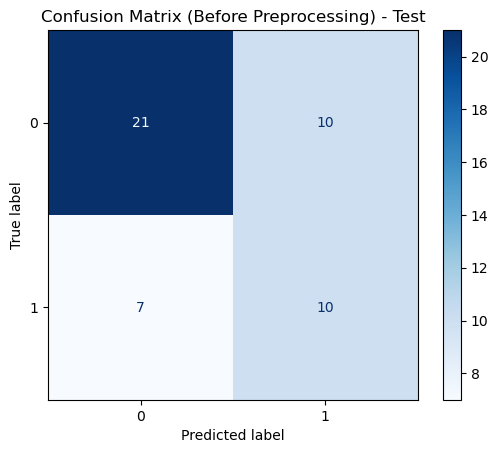

In [3]:
# ========== Evaluate Before Preprocessing (Raw Data) ==========
raw_preds = rf_raw.predict(X_test.reshape(len(X_test), -1))
raw_accuracy = accuracy_score(y_test_bin, raw_preds)

print(f"Test Accuracy (Before Preprocessing): {raw_accuracy * 100:.2f}%")

# ========== Confusion Matrix (Before Preprocessing) ==========
cm_raw = confusion_matrix(y_test_bin, raw_preds)
disp_raw = ConfusionMatrixDisplay(confusion_matrix=cm_raw, display_labels=rf_raw.classes_)
disp_raw.plot(cmap='Blues')
plt.title("Confusion Matrix (Before Preprocessing) - Test")
plt.show()



Test Accuracy (After Preprocessing): 83.33%


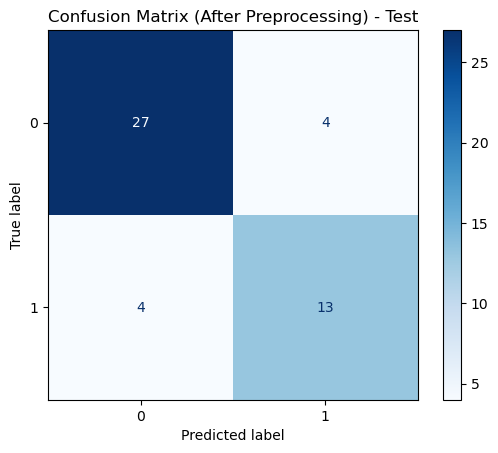

In [5]:

# ========== Train Random Forest (After Preprocessing) ==========
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(features_train, labels_train)

# ========== Evaluate After Preprocessing (Image Processing) ==========
rf_preds = rf_model.predict(features_test)
accuracy = accuracy_score(labels_test, rf_preds)
print(f"\nTest Accuracy (After Preprocessing): {accuracy * 100:.2f}%")



Enter start index:  1
Enter end index (inclusive):  15


Validation Sample #1 | GT: Normal | Pred: Normal Correct


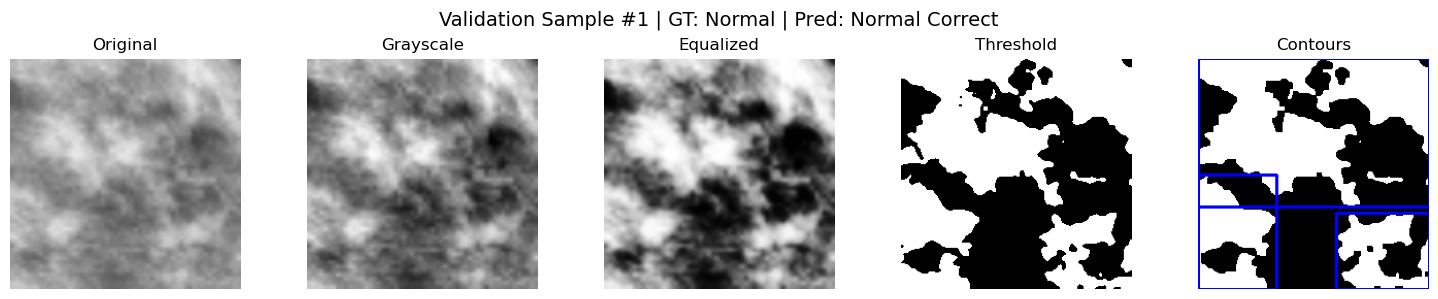

Validation Sample #2 | GT: Cancer | Pred: Cancer Correct


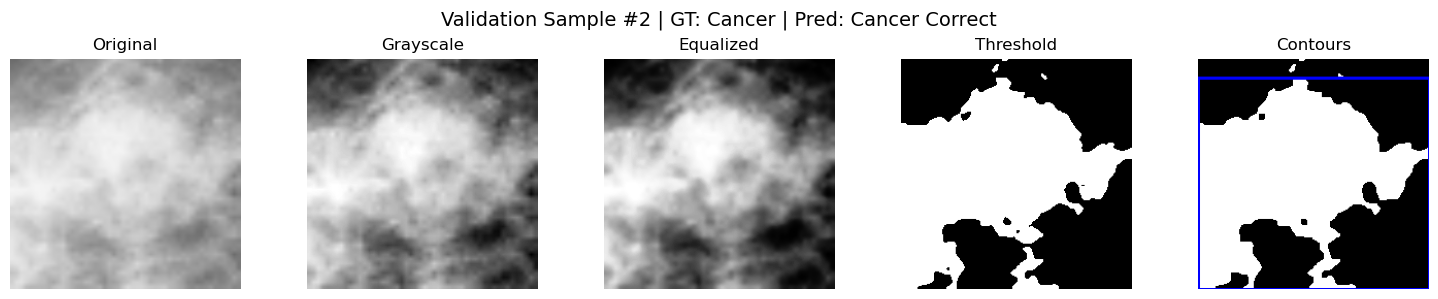

Validation Sample #3 | GT: Normal | Pred: Normal Correct


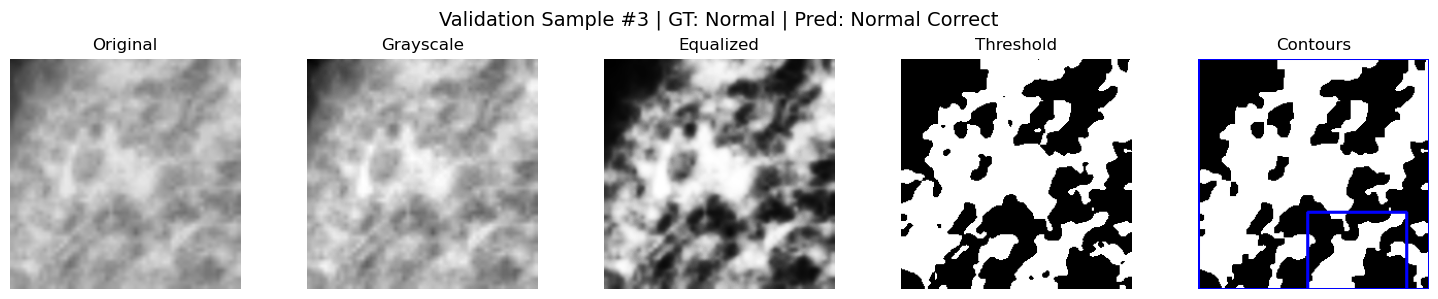

Validation Sample #4 | GT: Normal | Pred: Normal Correct


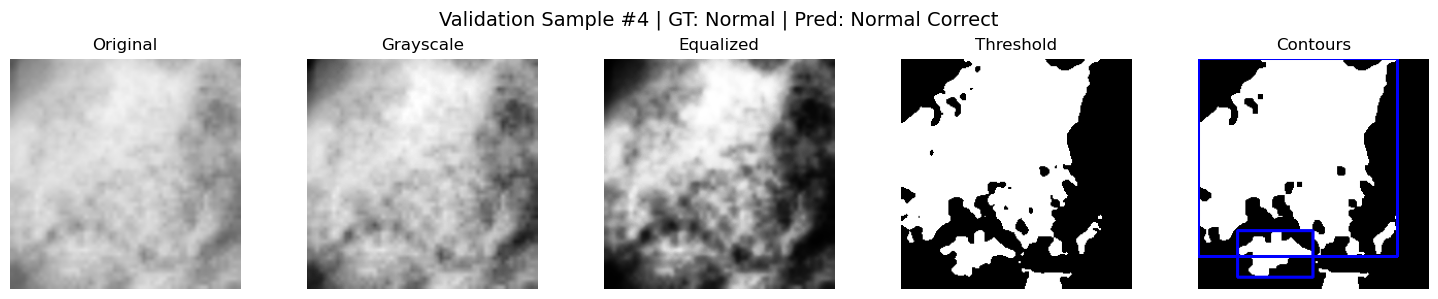

Validation Sample #5 | GT: Normal | Pred: Cancer Wrong


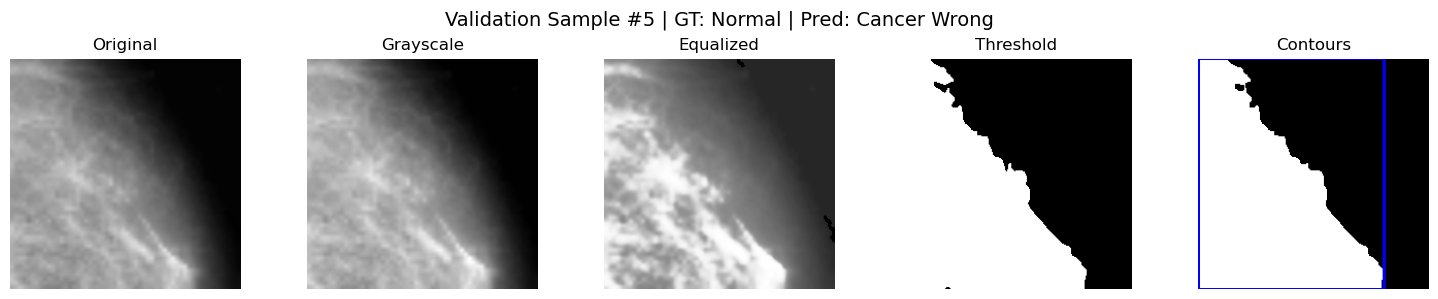

Validation Sample #6 | GT: Normal | Pred: Normal Correct


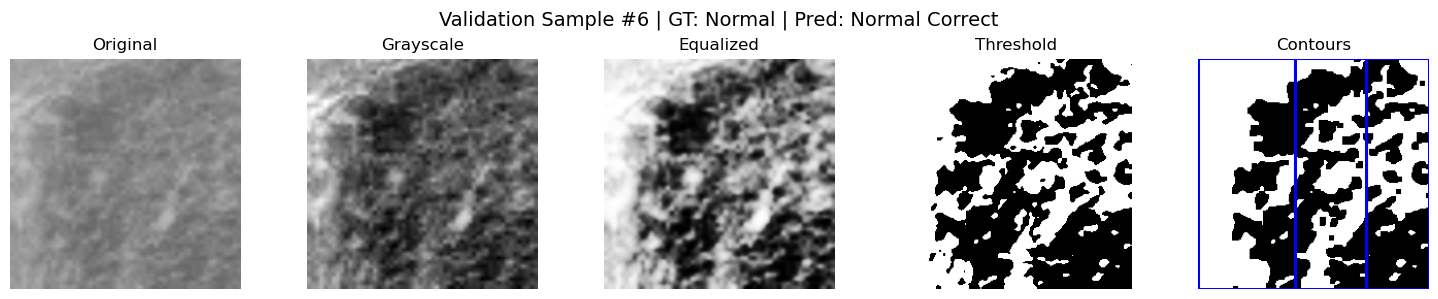

Validation Sample #7 | GT: Normal | Pred: Normal Correct


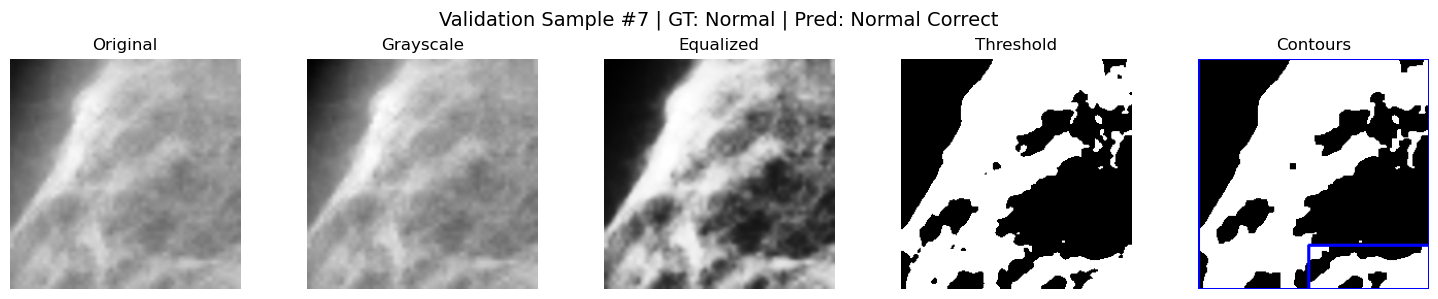

Validation Sample #8 | GT: Normal | Pred: Normal Correct


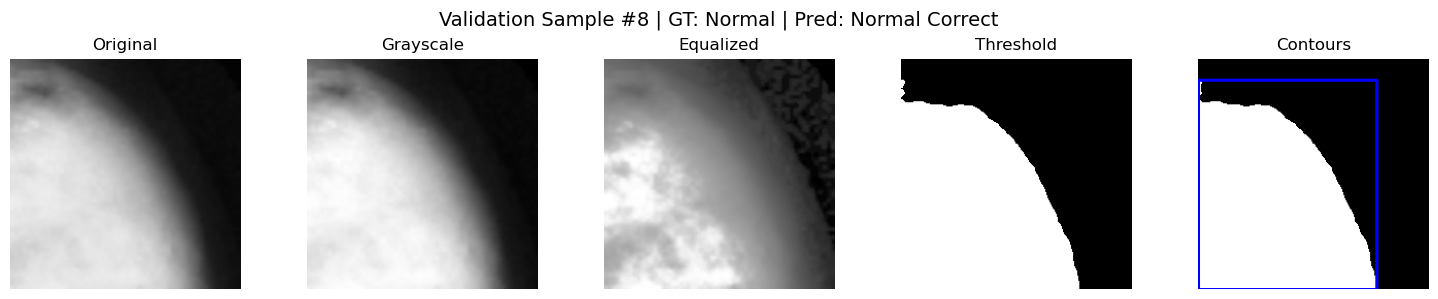

Validation Sample #9 | GT: Normal | Pred: Normal Correct


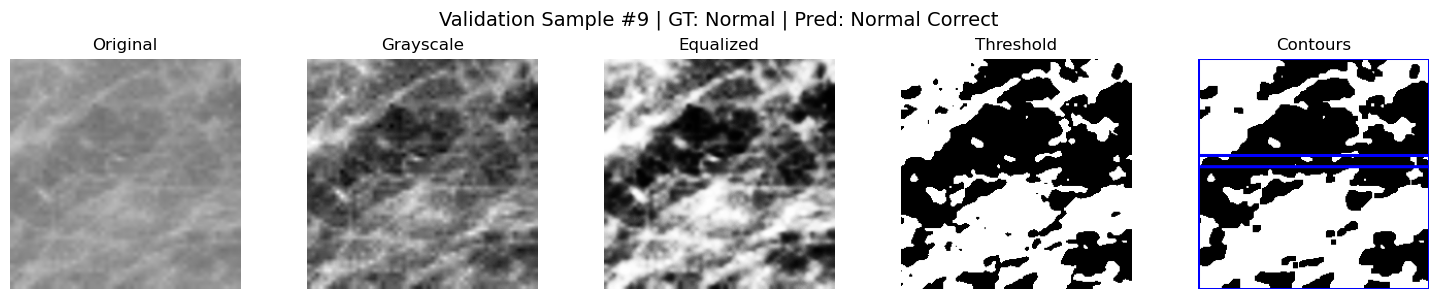

Validation Sample #10 | GT: Normal | Pred: Normal Correct


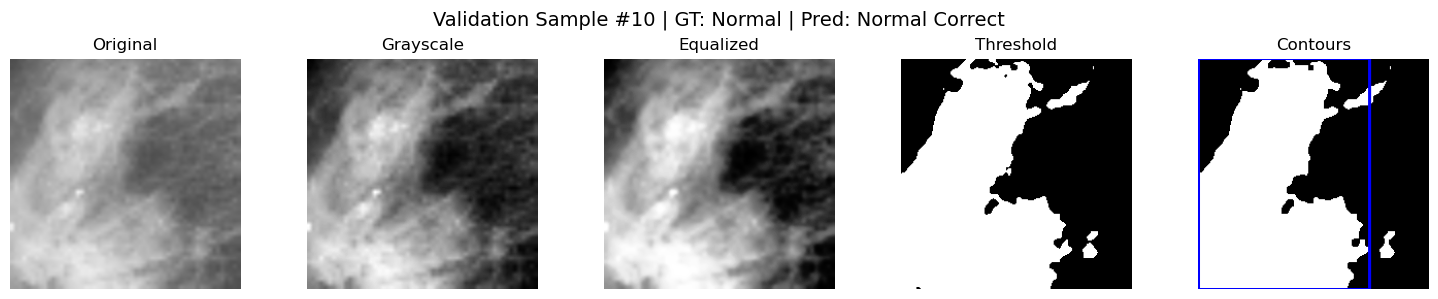

Validation Sample #11 | GT: Cancer | Pred: Normal Wrong


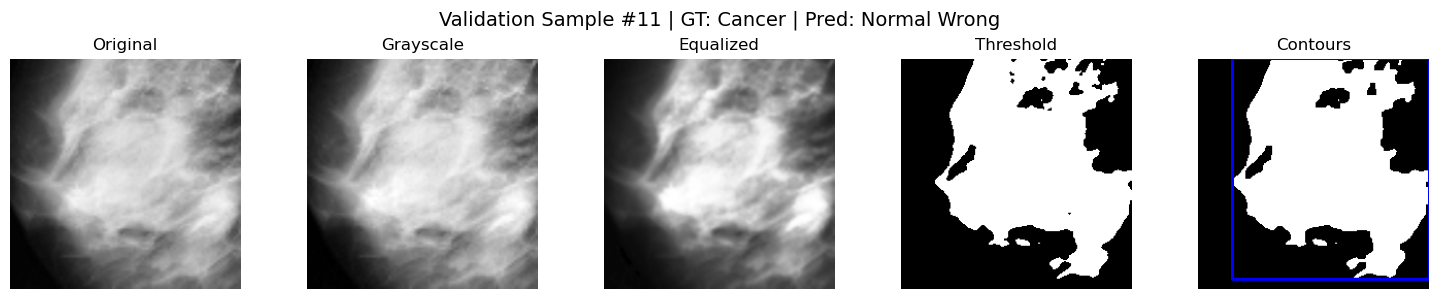

Validation Sample #12 | GT: Normal | Pred: Cancer Wrong


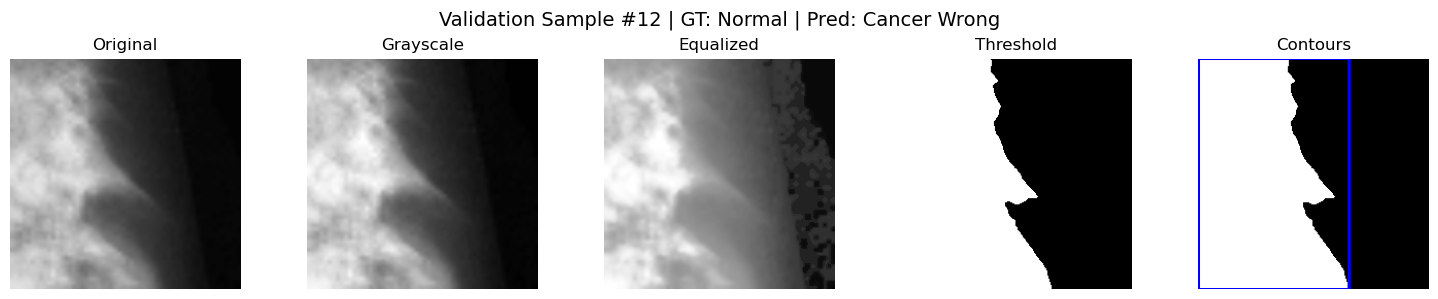

Validation Sample #13 | GT: Cancer | Pred: Cancer Correct


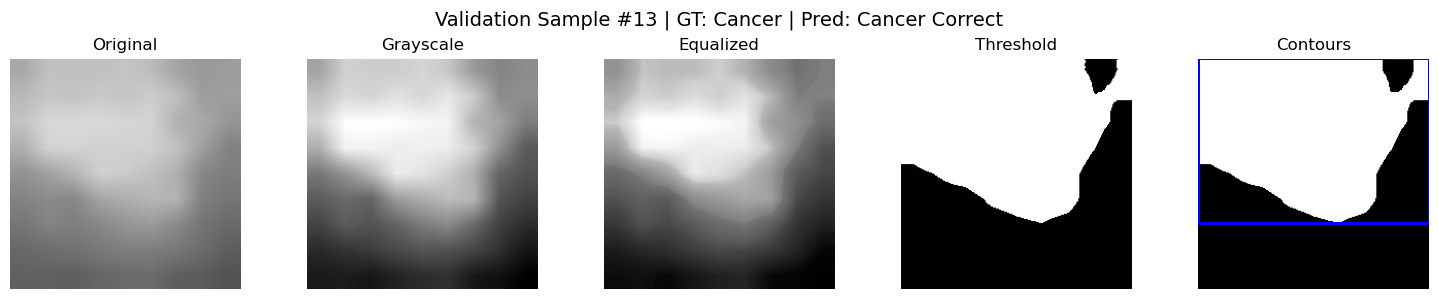

Validation Sample #14 | GT: Normal | Pred: Normal Correct


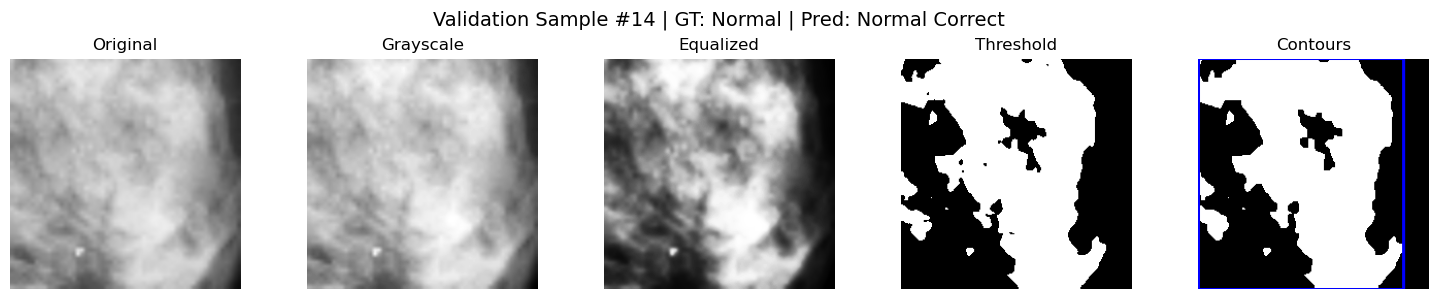

Validation Sample #15 | GT: Cancer | Pred: Normal Wrong


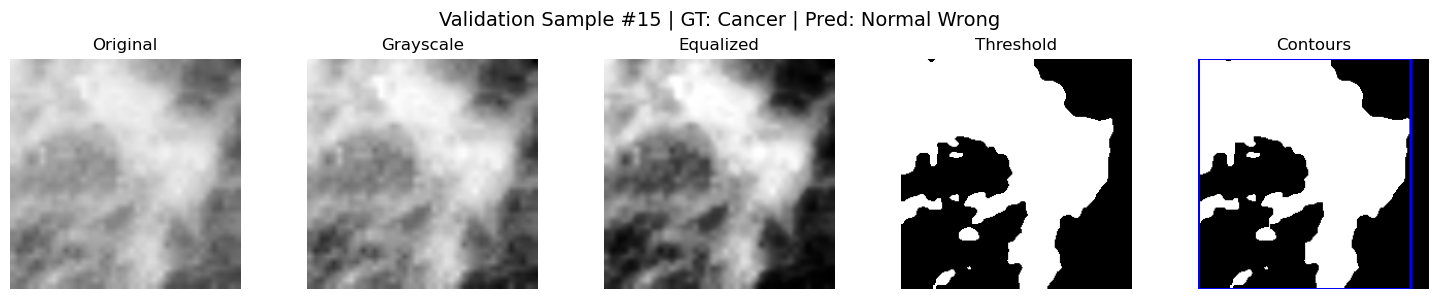

In [11]:
try:
    start = int(input("Enter start index: "))  # e.g., 0
    end = int(input("Enter end index (inclusive): ")) + 1  # e.g., 10 (inclusive)
except ValueError:
    print("Invalid input. Please enter integers.")
    exit()

label_map = {0: "Normal", 1: "Cancer"}

# Predict and visualize the selected range of validation images
for i in range(start, min(end, len(X_valid))):
    img = X_valid[i].astype(np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    equalized = cv2.equalizeHist(blurred)
    _, thresh = cv2.threshold(equalized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    morphed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=2)

    morphed_colored = cv2.cvtColor(morphed, cv2.COLOR_GRAY2BGR)
    contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if cv2.contourArea(cnt) > 1000:
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(morphed_colored, (x, y), (x + w, y + h), (0, 0, 255), 2)

    gt = labels_valid[i]
    pred = rf_model.predict([features_valid[i]])[0]
    correct = "Correct" if gt == pred else "Wrong"
    print(f"Validation Sample #{i} | GT: {label_map[gt]} | Pred: {label_map[pred]} {correct}")

    plt.figure(figsize=(15, 3))
    plt.suptitle(f"Validation Sample #{i} | GT: {label_map[gt]} | Pred: {label_map[pred]} {correct}", fontsize=14)
    plt.subplot(1, 5, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(gray, cmap='gray')
    plt.title("Grayscale")
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(equalized, cmap='gray')
    plt.title("Equalized")
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.imshow(thresh, cmap='gray')
    plt.title("Threshold")
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.imshow(morphed_colored)
    plt.title("Contours")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

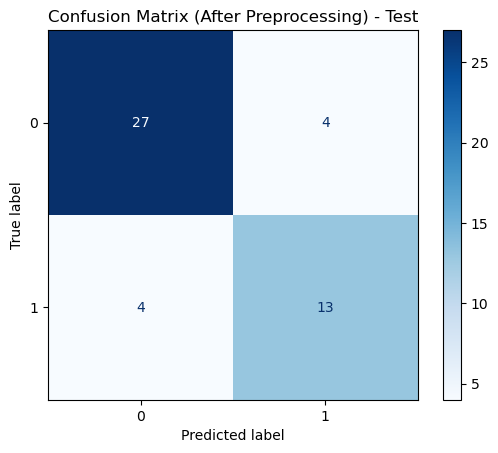

In [12]:

# ========== Confusion Matrix (After Preprocessing) ==========
cm_processed = confusion_matrix(labels_test, rf_preds)
disp_processed = ConfusionMatrixDisplay(confusion_matrix=cm_processed, display_labels=rf_model.classes_)
disp_processed.plot(cmap='Blues')
plt.title("Confusion Matrix (After Preprocessing) - Test")
plt.show()

In [7]:

# ========== Evaluate Test Accuracy (Image Processing) ==========
rf_preds_test = rf_model.predict(features_test)
test_acc = accuracy_score(labels_test, rf_preds_test)
print(f"Test Accuracy (Image Processing): {test_acc * 100:.2f}%")

# ========== Classification Report ==========
print(classification_report(labels_test, rf_preds, target_names=['Normal', 'Cancer']))

Test Accuracy (Image Processing): 83.33%
              precision    recall  f1-score   support

      Normal       0.87      0.87      0.87        31
      Cancer       0.76      0.76      0.76        17

    accuracy                           0.83        48
   macro avg       0.82      0.82      0.82        48
weighted avg       0.83      0.83      0.83        48

